0


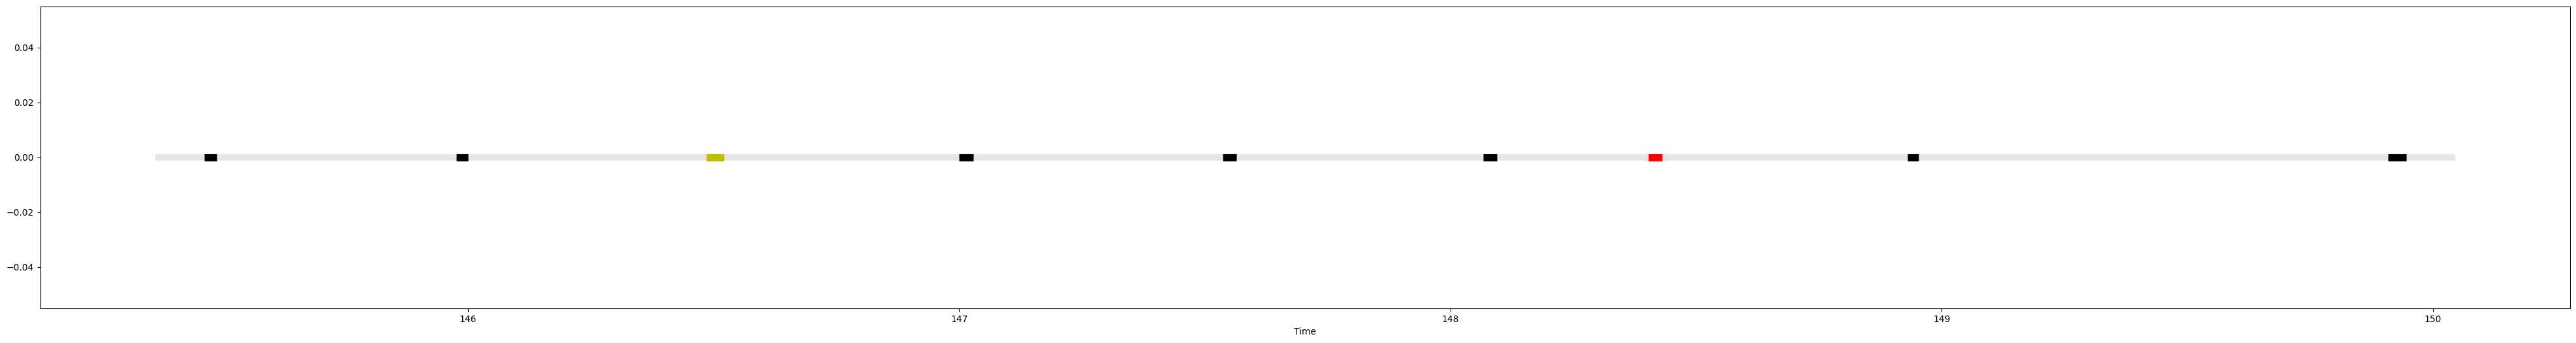

In [55]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MinuteLocator, SecondLocator
import numpy as np
import datetime as dt
import re


def load_intervals(filename: str):
    with open(filename, "r") as f:
        recording = False
        pause_start: tuple[float, str] | None = None
        intervals: list[tuple[str, float, float]] = []
        for line in f:
            line = line.strip()
            # if "DaCapo 23.11-chopin h2 starting" in line:
            #     recording = True
            # if not recording:
            #     continue
            if m := re.match(r"^\[([0-9\.]+)s\]\[info\]\[gc\] GC\(\d+\) ([a-zA-Z_-]+) start\. .+$", line):
                pause_start = float(m.group(1)), m.group(2)
            if m := re.match(r"^\[([0-9\.]+)s\]\[info\]\[gc\] GC\(\d+\) ([a-zA-Z_-]+) finished\. .+$", line):
                if pause_start is not None:
                    pause_end = float(m.group(1))
                    assert pause_start[1] == m.group(2)
                    intervals.append((pause_start[1], pause_start[0], pause_end))
                    pause_start = None
    # print(intervals)
    return intervals


def plot_intervals(filename: str, start_epoch: int = 0):
    plt.figure(figsize=(50, 6))
    intervals = load_intervals(filename)
    intervals = intervals[start_epoch:]
    # get first CM cycle +- 3 pauses
    first_initial_mark_index = next(i for i, x in enumerate(intervals) if x[0] == "InitialMark")
    first_final_mark_index = next(i for i, x in enumerate(intervals) if x[0] == "FinalMark")
    start = max(0, first_initial_mark_index - 3)
    end = min(len(intervals), first_final_mark_index + 3)
    intervals = intervals[start:end]
    # Background

    min_start = min(i[1] for i in intervals) - 0.1
    max_end = max(i[2] for i in intervals) + 0.1
    plt.hlines([0], [min_start], [max_end], "k", lw=7, alpha=0.1)

    # RC pauses
    start = [i[1] for i in intervals if i[0] == "RefCount"]
    end = [i[2] for i in intervals if i[0] == "RefCount"]
    ys = np.zeros_like(start)
    plt.hlines(ys, start, end, "k", lw=8)
    # print(len(start))
    # InitialMark pauses
    start = [i[1] for i in intervals if i[0] == "InitialMark"]
    end = [i[2] for i in intervals if i[0] == "InitialMark"]
    ys = np.zeros_like(start)
    plt.hlines(ys, start, end, "y", lw=8)
    # print(len(start))
    # FinalMark pauses
    start = [i[1] for i in intervals if i[0] == "FinalMark"]
    end = [i[2] for i in intervals if i[0] == "FinalMark"]
    ys = np.zeros_like(start)
    plt.hlines(ys, start, end, "r", lw=8)
    # Full pauses
    start = [i[1] for i in intervals if i[0] == "Full"]
    end = [i[2] for i in intervals if i[0] == "Full"]
    ys = np.zeros_like(start)
    plt.hlines(ys, start, end, "m", lw=8)
    print(len(start))
    plt.xlabel("Time")
    plt.show()


plot_intervals("../../x.log", start_epoch=258)

0


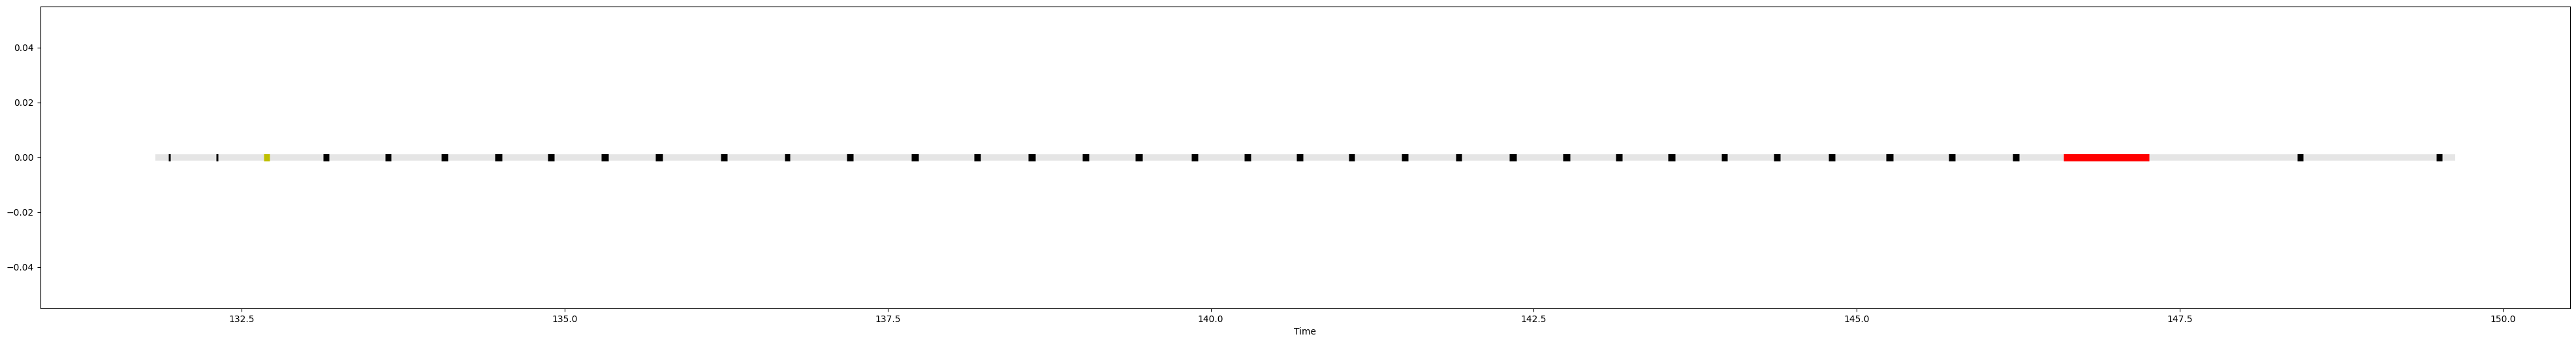

In [54]:
plot_intervals("../../y.log", start_epoch=277)

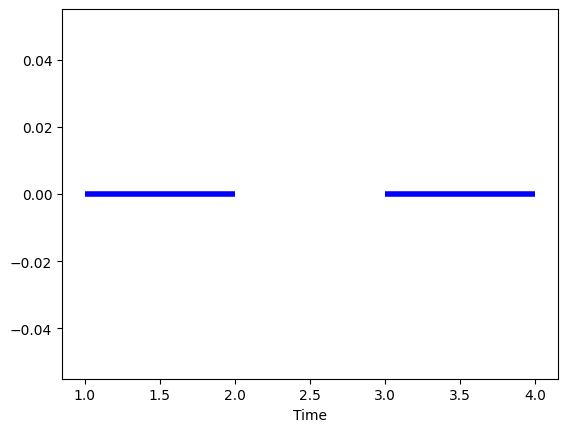

In [5]:
intervals = [
    (1, 2),
    (3, 4),
]

# conv = lambda s: dt.datetime.strptime(s, "%H:%M:%S")

# # Use numpy to read the data in.
# data = np.genfromtxt(a, converters={1: conv, 2: conv}, names=["caption", "start", "stop", "state"], dtype=None)
# cap, start, stop = data["caption"], data["start"], data["stop"]

# Check the status, because we paint all lines with the same color
# together
# is_ok = data["state"] == "OK"
# not_ok = np.logical_not(is_ok)

# Get unique captions and there indices and the inverse mapping
# captions, unique_idx, caption_inv = np.unique(cap, 1, 1)

# Build y values from the number of unique captions.
# y = (caption_inv + 1) / float(len(captions) + 1)


# Plot function
def timelines(y, xstart, xstop, color="b"):
    """Plot timelines at y from xstart to xstop with given color."""
    plt.hlines(y, xstart, xstop, color, lw=4)
    plt.vlines(xstart, y + 0.03, y - 0.03, color, lw=2)
    plt.vlines(xstop, y + 0.03, y - 0.03, color, lw=2)


# Plot ok tl black
# timelines(y[is_ok], start[is_ok], stop[is_ok], "k")
# # Plot fail tl red
# timelines(y[not_ok], start[not_ok], stop[not_ok], "r")

plt.hlines([0, 0], [1, 3], [2, 4], "b", lw=4)

# Setup the plot
# ax = plt.gca()
# ax.xaxis_date()
# myFmt = DateFormatter("%H:%M:%S")
# ax.xaxis.set_major_formatter(myFmt)
# ax.xaxis.set_major_locator(SecondLocator(interval=20))  # used to be SecondLocator(0, interval=20)

# To adjust the xlimits a timedelta is needed.
# delta = (stop.max() - start.min()) / 10

# plt.yticks(y[unique_idx], captions)
# plt.ylim(0, 1)
# plt.xlim(start.min() - delta, stop.max() + delta)
plt.xlabel("Time")
plt.show()